# Ungraded Lab: Single Layer LSTM

So far in this course, you've been using mostly basic dense layers and embeddings to build your models. It detects how the combination of words (or subwords) in the input text determines the output class. In the labs this week, you will look at other layers you can use to build your models. Most of these will deal with *Recurrent Neural Networks*, a kind of model that takes the ordering of inputs into account. This makes it suitable for different applications such as parts-of-speech tagging, music composition, language translation, and the like. For example, you may want your model to differentiate sentiments even if the words used in two sentences are the same:

```
1: My friends do like the movie but I don't. --> negative review
2: My friends don't like the movie but I do. --> positive review
```

The first layer you will be looking at is the [*LSTM (Long Short-Term Memory)*](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). In a nutshell, it computes the state of a current timestep and passes it on to the next timesteps where this state is also updated. The process repeats until the final timestep where the output computation is affected by all previous states. Not only that, it can be configured to be bidirectional so you can get the relationship of later words to earlier ones. If you want to go in-depth of how these processes work, you can look at the [Sequence Models](https://www.coursera.org/learn/nlp-sequence-models) course of the Deep Learning Specialization. For this lab, you can take advantage of Tensorflow's APIs that implements the complexities of these layers for you. This makes it easy to just plug it in to your model. Let's see how to do that in the next sections below.

**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running it on your local machine might result in some of the code blocks throwing errors.

## Load the dataset

You will load the [IMDB Reviews dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) via Tensorflow Datasets as you've done last week:

In [ ]:
import tensorflow_datasets as tfds

# The dataset is already downloaded for you. For downloading you can use the code below.
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="./data/", download=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling data/imdb_reviews/plain_text/incomplete.5ZYDR2_1.0.0/imdb_reviews-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling data/imdb_reviews/plain_text/incomplete.5ZYDR2_1.0.0/imdb_reviews-test.tfrecord*...:   0%|          …

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling data/imdb_reviews/plain_text/incomplete.5ZYDR2_1.0.0/imdb_reviews-unsupervised.tfrecord*...:   0%|  …

Dataset imdb_reviews downloaded and prepared to data/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
# View 4 training examples
print('Four training examples...')
for example in imdb['train'].take(4):
  print(example)
print("="*50)

# View 4 test examples
print('\nFour test examples...')
for example in imdb['test'].take(4):
  print(example)
print("="*50)

Four training examples...
(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, bei

Then, you will separate the reviews and labels.

In [ ]:
# Extract the train reviews and labels
train_reviews = imdb['train'].map(lambda review, label: review)
train_labels = imdb['train'].map(lambda review, label: label)

# Extract the test reviews and labels
test_reviews = imdb['test'].map(lambda review, label: review)
test_labels = imdb['test'].map(lambda review, label: label)

## Prepare the dataset

You will use subword tokenization in this lab. We'll provide the vocabulary text file already so you won't need to generate it yourself.

In [ ]:
import os
try:
    import wget
except ModuleNotFoundError:
    print("Installing wget module...")
    !pip install wget
    import wget

def download_dataset(url, folder, filename):
    # Check if the folder exists, otherwise, create it
    if not os.path.exists(folder):
        os.makedirs(folder)

    file_path = os.path.join(folder, filename)

    # Check if the file has already been downloaded
    if not os.path.exists(file_path):
        print(f"Downloading file from {url}...")
        wget.download(url, out=folder)
        print("\nDownload completed.")
    else:
        print("The file has already been downloaded.")

# Specify the URL of the file, the destination folder, and the filename
url = "https://storage.googleapis.com/tensorflow-1-public/course3/imdb_vocab_subwords.txt"
folder = "Vocabulary"
filename = "imdb_vocab_subwords.txt"

# Call the function to download the file.
download_dataset(url, folder, filename)

Installing wget module...
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=f655e04dffa52a1f784b4242e87bd9f5c7b49b0a463647b72136251c0489dcba
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget

Download completed.


You can just pass this directly to the `WordPieceTokenizer` class to instantiate the tokenizer.

In [ ]:
import keras_nlp

# Initialize the subword tokenizer
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='./Vocabulary/imdb_vocab_subwords.txt'
)

You can then get the train and test splits and generate padded sequences.

*Note: To make the training go faster in this lab, you will increase the batch size that Laurence used in the lecture. In particular, you will use `256` and this takes roughly a minute to train per epoch. In the video, Laurence used `16` which takes around 4 minutes per epoch.*

In [ ]:
import tensorflow as tf

# Data pipeline and padding parameters
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 256
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [ ]:
def padding_func(sequences):
  '''
  Generates padded sequences from a tf.data.Dataset.

  Args:
      sequences (tf.data.Dataset): Dataset containing the sequences to be padded.

  Returns:
      tf.data.Dataset: Dataset containing the padded sequences.
  '''

  # Put all elements in a single ragged batch
  sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

  # Output a tensor from the single batch
  sequences = sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(), truncating=TRUNC_TYPE, padding=PADDING_TYPE)

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

  return padded_sequences

In [ ]:
def process_reviews_with_tokenizer(reviews, labels, subword_tokenizer, padding_func):
    """
    Generate integer sequences using the subword tokenizer, apply padding, and combine sequences with labels.

    Args:
        reviews (tf.data.Dataset): Dataset containing text reviews.
        labels (tf.data.Dataset): Dataset containing labels.
        subword_tokenizer: Subword tokenizer used to tokenize the reviews.
        padding_func: Function used to apply padding to the tokenized sequences.

    Returns:
        tf.data.Dataset: Dataset containing the tokenized and padded sequences along with their labels.
    """
    # Generate integer sequences using the subword tokenizer and apply padding
    sequences_subword = reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

    # Combine the integer sequences and labels
    dataset_vectorized = tf.data.Dataset.zip((sequences_subword, labels))

    return dataset_vectorized

train_dataset_vectorized = process_reviews_with_tokenizer(train_reviews, train_labels, subword_tokenizer, padding_func)
test_dataset_vectorized = process_reviews_with_tokenizer(test_reviews, test_labels, subword_tokenizer, padding_func)

for review, label in train_dataset_vectorized.take(4):
    print("Tokenized and padded review:", review)
    print("Label:", label)
    print("="*50)

Tokenized and padded review: tf.Tensor([  0   0   0 ... 320 171  15], shape=(4008,), dtype=int32)
Label: tf.Tensor(0, shape=(), dtype=int64)
Tokenized and padded review: tf.Tensor([  0   0   0 ... 193 194  15], shape=(4008,), dtype=int32)
Label: tf.Tensor(0, shape=(), dtype=int64)
Tokenized and padded review: tf.Tensor([   0    0    0 ...  644 1910   15], shape=(4008,), dtype=int32)
Label: tf.Tensor(0, shape=(), dtype=int64)
Tokenized and padded review: tf.Tensor([   0    0    0 ...  171 2594   15], shape=(4008,), dtype=int32)
Label: tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
def optimize_dataset(dataset_vectorized, shuffle=False):
    '''
    Optimizes the dataset for training.

    Args:
        dataset_vectorized (tf.data.Dataset): Dataset containing the vectorized data.
        shuffle (bool): Indicates whether to shuffle the dataset or not. Default is False.

    Returns:
        tf.data.Dataset: Optimized dataset with caching, prefetching, and batching applied.
    '''
    dataset_final = dataset_vectorized.shuffle(SHUFFLE_BUFFER_SIZE) if shuffle else dataset_vectorized
    dataset_final = dataset_final.cache()
    dataset_final = dataset_final.prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
    dataset_final = dataset_final.batch(BATCH_SIZE)
    return dataset_final

train_dataset_final = optimize_dataset(train_dataset_vectorized, shuffle=True)
test_dataset_final = optimize_dataset(test_dataset_vectorized)

## Build and compile the model

Now you will build the model. You will simply swap the `Flatten` or `GlobalAveragePooling1D` from before with an `LSTM` layer. Moreover, you will nest it inside a [Biderectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) layer so the passing of the sequence information goes both forwards and backwards. These additional computations will naturally make the training go slower than the models you built last week. You should take this into account when using RNNs in your own applications.

In [ ]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

class LSTMModel:
    def __init__(self, vocab_size, dense_dim, embedding_dim, lstm_dim):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_dim = lstm_dim
        self.dense_dim = dense_dim
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Input(shape=(None,)),
            Embedding(self.vocab_size, EMBEDDING_DIM),
            Bidirectional(LSTM(self.lstm_dim)),
            Dense(self.dense_dim, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        return model

    def compile_model(self):
        self.model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

    def train_model(self, train_data, test_data, num_epochs, verbose):
        history = self.model.fit(
            train_data,
            epochs=num_epochs,
            validation_data=test_data,
            verbose=verbose
        )
        return history

    def summary(self):
        self.model.summary()

In [ ]:
# Model Parameters
EMBEDDING_DIM = 64
LSTM_DIM = 64
DENSE_DIM = 64

# Create an instance of the SentimentModel class
model = LSTMModel(subword_tokenizer.vocabulary_size(), DENSE_DIM, EMBEDDING_DIM, LSTM_DIM)

# Compile the model
model.compile_model()

# Print the summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 64)            │         488,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 563,009 (2.15 MB)

 Trainable params: 563,009 (2.15 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

Now you can start training. Using the default parameters above, you should reach around 95% training accuracy and 84% validation accuracy. You can visualize the results using the same plot utilities. See if you can still improve on this by modifying the hyperparameters or by training with more epochs.

In [ ]:
NUM_EPOCHS = 10

history = model.train_model(train_data=train_dataset_final, test_data=test_dataset_final, num_epochs=NUM_EPOCHS, verbose=1)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 60s 549ms/step - accuracy: 0.6296 - loss: 0.6141 - val_accuracy: 0.8247 - val_loss: 0.3935
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 61s 623ms/step - accuracy: 0.8583 - loss: 0.3368 - val_accuracy: 0.8640 - val_loss: 0.3248
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 54s 548ms/step - accuracy: 0.8491 - loss: 0.3439 - val_accuracy: 0.8355 - val_loss: 0.4011
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 545ms/step - accuracy: 0.8895 - loss: 0.2714 - val_accuracy: 0.8408 - val_loss: 0.3769
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 546ms/step - accuracy: 0.9134 - loss: 0.2246 - val_accuracy: 0.8640 - val_loss: 0.3679
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 544ms/step - accuracy: 0.9286 - loss: 0.1921 - val_accuracy: 0.8624 - val_loss: 0.3846
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 544ms/step - accuracy: 0.9255 - loss: 0.1985 - val_accuracy: 0.8549 - val_loss: 0.3806
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 90s 629ms/step - accuracy: 0.9243 - loss: 0.1949 - val_accu

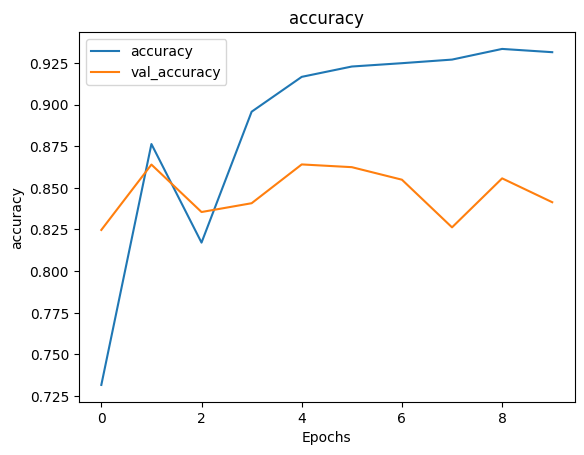

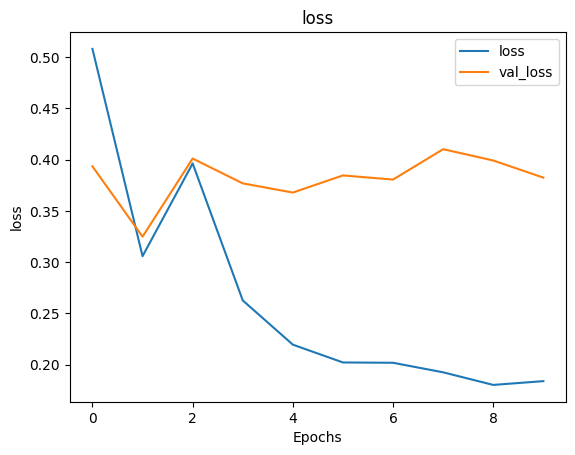

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    """
    Plots training and validation metrics over epochs.

    Args:
        history (History): History object returned by the fit method of a Keras model.
        metric (str): Metric name to plot (e.g., "accuracy", "loss").

    Returns:
        None: Displays a plot showing the training and validation metrics over epochs.
    """
    # Convert metric to lowercase
    metric = metric.lower()

    # Check if the metric exists in the history
    if metric not in history.history or f'val_{metric}' not in history.history:
        raise ValueError(f"Metric '{metric}' or 'val_{metric}' not found in history.")

    plt.figure()  # Create a new figure
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

try:
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
except ValueError as e:
  print("Error:", e)

## Save the history

In [ ]:
import json
from google.colab import files

def save_history(history, filename):
    """
    Saves the training history to a file.

    Args:
        history (History): History object returned by the fit method of a Keras model.
        filename (str): Name of the file where the history will be saved.

    Returns:
        None: The function saves the history to the specified file.
    """
    # Save the dictionary to a JSON file
    with open(filename, 'w') as file:
        json.dump(history.history, file)

    # Download the JSON file
    files.download(filename)

save_history(history, 'history.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
from google.colab import files

def download_history(history, filename):
    """
    Saves the training history to a pickle file and downloads it.

    Args:
        history (History): History object returned by the fit method of a Keras model.
        filename (str): Name of the file where the history will be saved.

    Returns:
        None: The function saves the history to a pickle file and triggers its download.
    """
    # Save the history to a pickle file
    with open(filename, 'wb') as f:
        pickle.dump(history.history, f)

    # Download the pickle file
    files.download(filename)

download_history(history, 'history.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Wrap Up

In this lab, you got a first look at using LSTM layers to build Recurrent Neural Networks. You only used a single LSTM layer but this can be stacked as well to build deeper networks. You will see how to do that in the next lab. Before doing so, run the cell below to free up resources for the next lab. You might see a pop-up about restarting the kernel afterwards. You can safely ignore it and just press `Ok`. You can then close this lab, then go back to the classroom. See you there!

In [ ]:
# Shutdown the kernel to free up resources.
# Note: You can expect a pop-up when you run this cell. You can safely ignore that and just press `Ok`.

from IPython import get_ipython

k = get_ipython().kernel

k.do_shutdown(restart=False)